In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(15, 12))

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
# read the data
dmds = pd.read_csv('./input/diamonds.csv')
dmds.drop('Unnamed: 0', axis=1, inplace=True)
dmds.head(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


In [3]:
# encode cut, color and clarity
categorical_cols = ['cut', 'color', 'clarity']
for c in categorical_cols:
    dmds[c] = pd.factorize(dmds[c])[0]
dmds.head(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,0,0,0,61.5,55.0,326,3.95,3.98,2.43
1,0.21,1,0,1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,0,2,56.9,65.0,327,4.05,4.07,2.31


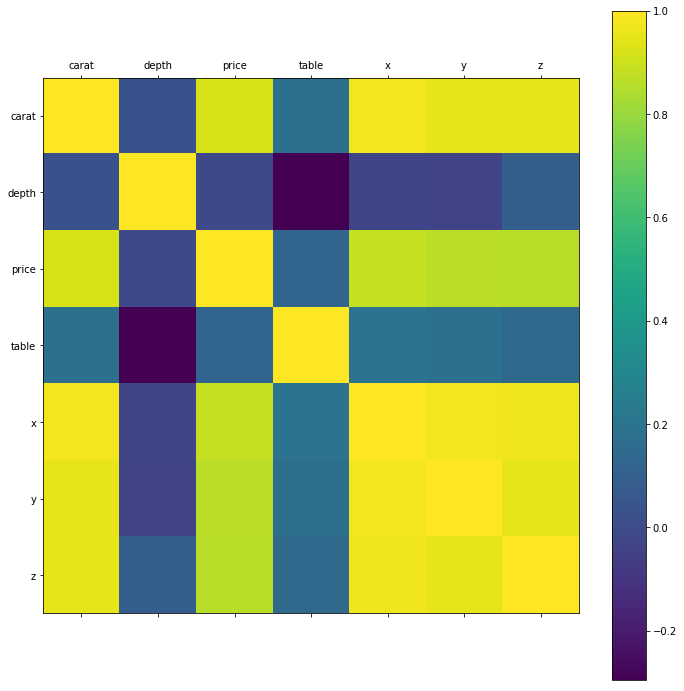

In [4]:
# graphs
# use a reduced set without categorical columns
dmds_reduced = dmds[dmds.columns.difference(['cut', 'color', 'clarity'])]

# correlations
plt.matshow(dmds_reduced.corr())
plt.colorbar()
tick_marks = dmds_reduced.columns.values
plt.xticks(np.arange(tick_marks.size), tick_marks)
plt.yticks(np.arange(tick_marks.size), tick_marks)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


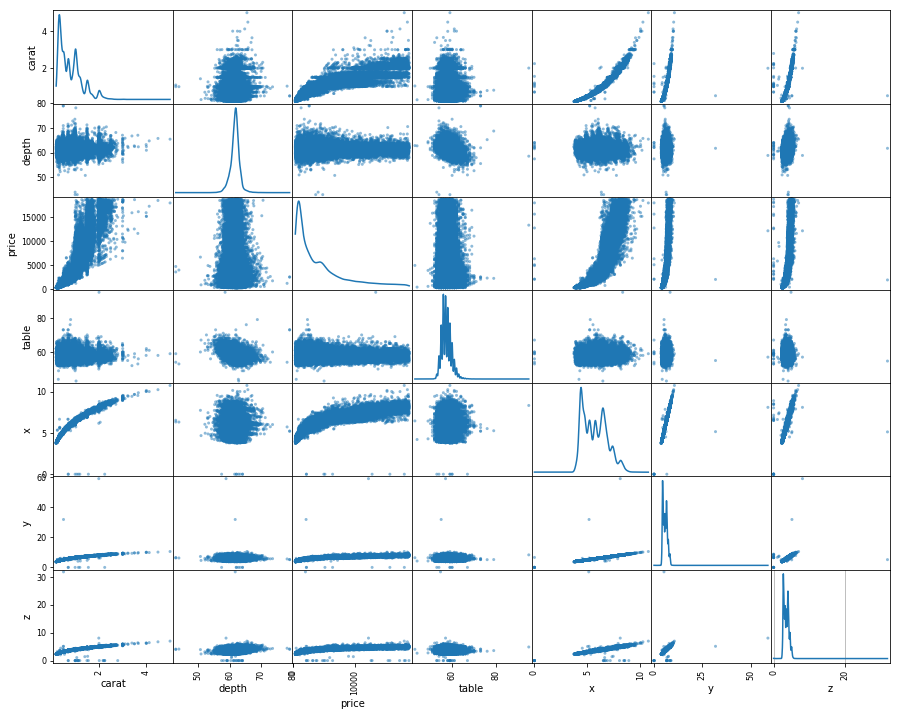

In [5]:
# let's compare the correlation visually
from pandas.tools.plotting import scatter_matrix

scatter_matrix(dmds_reduced, diagonal='kde')
plt.grid()
plt.show()

In [6]:
# split
from sklearn.model_selection import train_test_split

X, y = dmds.iloc[:, dmds.columns != 'price'].values, dmds.iloc[:, dmds.columns == 'price'].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Regression ##

Let's compare the basic linear regression and random forest regression. SVR's were lagging on my PC, hence these are commented out

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

models = [('LR', LinearRegression(n_jobs=-1)),
          ('RF', RandomForestRegressor(n_estimators=100, criterion='mse', random_state=1, n_jobs=-1)),
           ('SVR-lin', SVR(kernel='linear', C=1e3)),
           ('SVR-rbf', SVR(kernel='rbf', C=1e3)),
           ('SVR-poly', SVR(kernel='poly', C=1e3, degree=2))
         ]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=123)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.858492 (0.023036)
RF: 0.978710 (0.001179)
SVR-lin: 0.854494 (0.010765)
SVR-rbf: 0.945624 (0.000748)


In [9]:
# compute ms-error and R^2
for name, model in models:
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('%s: MSE train: %.4f, test: %.4f' % (name, mean_squared_error(y_train, y_train_pred),
                                           mean_squared_error(y_test, y_test_pred)))
    print('%s: R^2 train: %.4f, test: %.4f' % (name, r2_score(y_train, y_train_pred),
                                           r2_score(y_test, y_test_pred)))

LR: MSE train: 2035495.2343, test: 1971856.8738
LR: R^2 train: 0.8721, test: 0.8762
RF: MSE train: 45577.3775, test: 339621.2456
RF: R^2 train: 0.9971, test: 0.9787


Random forests estimator looks promising, let's compare algorithms visually

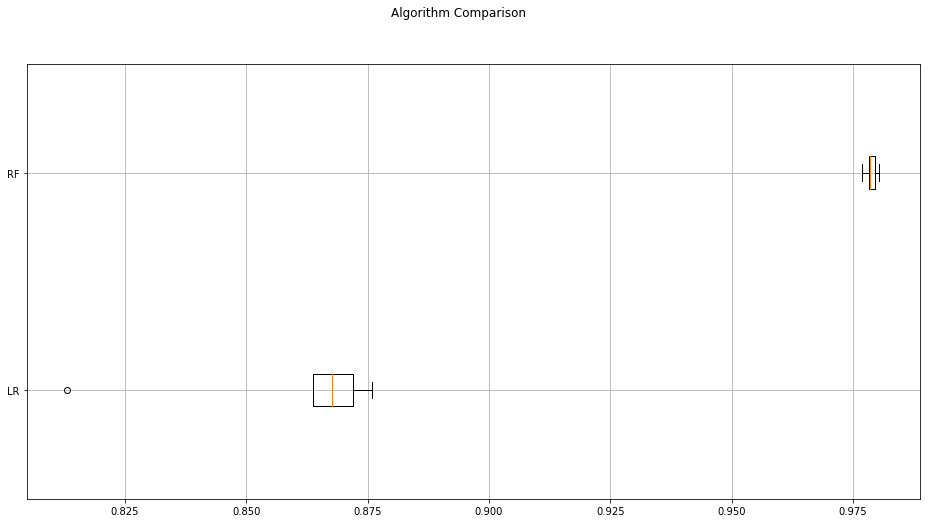

In [10]:
# Compare Algorithms
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, vert=False)
ax.set_yticklabels(names)
plt.grid()
plt.show()

## Classification by price ranges ##
Let's split the price by price bands and try to train different classifiers on it

### 10 classes ###

In [11]:
# convert price data to classes
n_classes = 10

y_classes = np.linspace(0, y.max(), n_classes)
y_train_cl = np.digitize(y_train, bins=y_classes)
y_test_cl = np.digitize(y_test, bins=y_classes)

print('Price classes: %s' % (y_classes))

Price classes: [     0.           2091.44444444   4182.88888889   6274.33333333
   8365.77777778  10457.22222222  12548.66666667  14640.11111111
  16731.55555556  18823.        ]


In [12]:
# test different models on the data
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('NB', GaussianNB()),
          ('SVM-lin', SVC(kernel='linear')),
          ('SVM-rbf', SVC(kernel='rbf')),
          ('RF', RandomForestClassifier()),
          ('MLP', MLPClassifier(alpha=1)),
          ('ADA', AdaBoostClassifier())]

In [13]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train_cl, cv=kfold, n_jobs=-1)    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.703665 (0.006603)
KNN: 0.774829 (0.005927)
CART: 0.841967 (0.005082)
NB: 0.731554 (0.005018)
SVM-lin: 0.773346 (0.003910)
SVM-rbf: 0.826076 (0.005934)
RF: 0.858917 (0.005154)
MLP: 0.730997 (0.012854)
ADA: 0.619207 (0.015580)


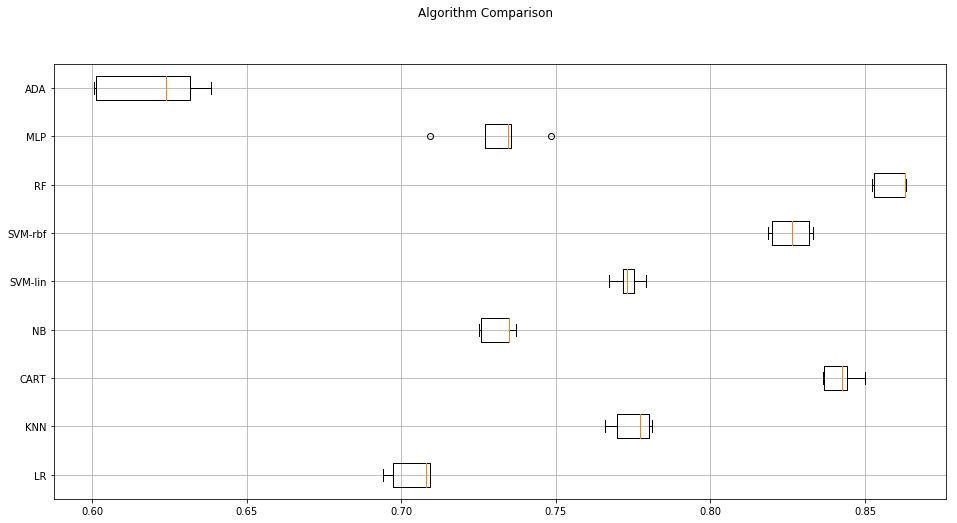

In [14]:
# Compare Algorithms
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, vert=False)
ax.set_yticklabels(names)
plt.grid()
plt.show()

### 5 classes ###

In [15]:
# convert price data to classes
n_classes = 5

y_classes = np.linspace(0, y.max(), n_classes)
y_train_cl = np.digitize(y_train, bins=y_classes)
y_test_cl = np.digitize(y_test, bins=y_classes)

print('Price classes: %s' % (y_classes))

Price classes: [     0.     4705.75   9411.5   14117.25  18823.  ]


In [16]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train_cl, cv=kfold, n_jobs=-1)    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.849171 (0.006962)
KNN: 0.890752 (0.003006)
CART: 0.920944 (0.003309)
NB: 0.817946 (0.004019)
SVM-lin: 0.883363 (0.003734)
SVM-rbf: 0.921977 (0.003641)
RF: 0.933524 (0.003794)
MLP: 0.869141 (0.015079)
ADA: 0.790748 (0.039637)


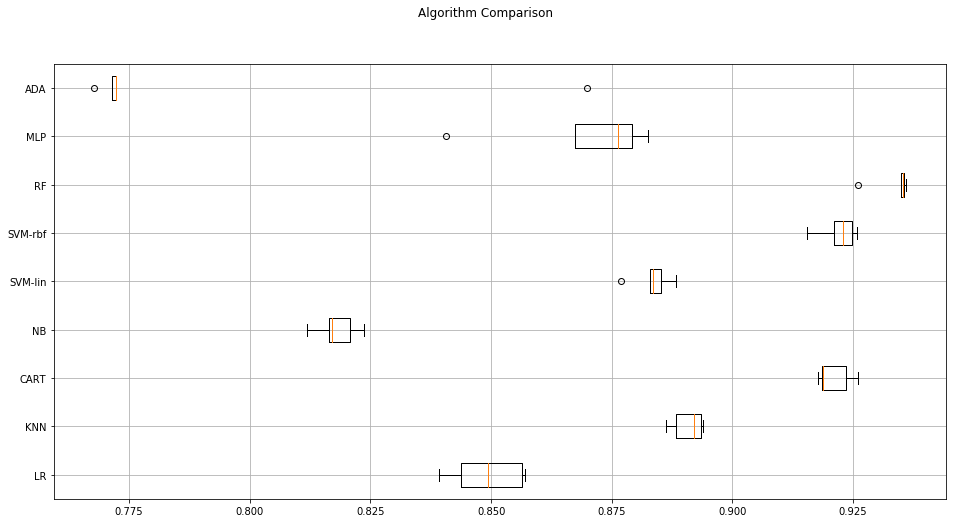

In [17]:
# Compare Algorithms
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, vert=False)
ax.set_yticklabels(names)
plt.grid()
plt.show()

The random forest classifier has won in both scenarios with 5 & 10 classes. In general, classification accuracy is better with 5 classes